This exercise follows [Corporate Finance Institute](https://corporatefinanceinstitute.com/)'s rundown on  [Capital Allocation Line and Optimal Portfolio](https://corporatefinanceinstitute.com/resources/knowledge/finance/capital-allocation-line-cal-and-optimal-portfolio/), alongside annotations and workings by myself. 

# Capital Allocation Line (CAL) and Optimal Portfolio

The Capital Allocation Line (CAL) is a line that graphically depicts the risk-and-reward profile of assets, and can be used to find the optimal portfolio. 

This notebook will describe the process to construct the CAL for a 2-asset portfolio in Python, and provide an interactive wrapper around it for the user to observe the effects of varying parameters on the shape of the efficient frontier.

In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks')
import ipywidgets as widgets
from IPython.display import display
%matplotlib inline

## Portfolio expected return and variance

For a portfolio $P$ consisting of two assets, asset A and asset B, the portfolio's expected return is a weighted average of its individual assets’ expected returns:

$$E(r_P) = w_A * E(r_A) + w_B * E(r_B) $$

Where $w_A, w_B$ are the respective weights for the two assets, and $E(r_A), E(r_B)$ are the respective expected returns.

The variance of a portfolio is not just the weighted average of the variance of individual assets but also depends on the covariance and correlation of the two assets. The formula for portfolio variance is given as:

$$\sigma^2(R_P) = \sigma^2_A w^2_A + \sigma^2_Bw^2_B + 2w_Aw_B\sigma_A\sigma_B\rho_{A,B} \iff \sigma^2_A w^2_A + \sigma^2_Bw^2_B + 2w_A w_B \text{Cov}(A, B)$$

The conversion between correlation and covariance is given as: $\rho(r_A, r_B) = \text{Cov}(r_A, r_B) / \sigma_A \sigma_B$.

The variance of portfolio return is greater when the covariance of the two assets is positive, and less when negative. Since variance represents risk, the portfolio risk is lower when its asset components possess negative covariance. 

Diversification is a technique that minimizes portfolio risk by investing in assets with negative covariance.

## The efficient frontier

A portfolio frontier is a graph that maps out all possible portfolios with different asset weight combinations, with levels of portfolio standard deviation graphed on the x-axis and portfolio expected return on the y-axis.

To construct a portfolio frontier, we first assign values for each asset's expected returns and standard deviations. 

We then generate list of weights for the assets, which is a linearly-spaced array consisting of $n$ points between 0 and 1. 

In [73]:
# asset A
r_A = 0.15
std_A = 0.18
A = r_A, std_A

# asset B
r_B = 0.07
std_B = 0.1
B = r_B, std_B

# correlation of A and B
rho_AB = -0.3

# generate list of weights between the two asset classes
n_points = 25
weights = np.array([[w,1-w] for w in np.linspace(0,1,n_points)])

In [93]:
# function to compute portfolio returns
def p_returns(weights, r_A, r_B):
    '''
    computes a column vector for portfolio expected returns
    given an array consisting of the asset weights
    '''
    return weights @ np.array([[r_A], [r_B]])

# function to compute portfolio variance
def p_var(weights, std_A, std_B, rho_AB):
    '''
    computes portfolio variance at every level of weights
    '''
    var_A, var_B = std_A**2, std_B**2
    out = []
    for e in weights:
        var = (var_A**2)*(e[0]**2) + (var_B**2)*(e[1]**2) + np.prod([2,e[0],e[1],var_A,var_B,rho_AB])
        out.append(var**0.5)
    return np.array(out)[np.newaxis].T

We then use the scatter chart with smooth lines to plot the portfolio’s expected return and standard deviation. The result is shown on the graph below, where each dot on the plot represents a portfolio constructed under an asset weight combination.

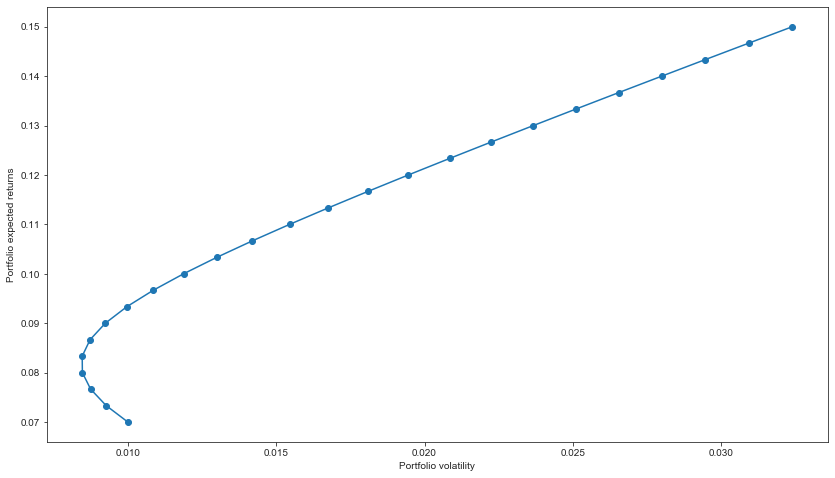

In [112]:
rets = p_returns(weights=weights, r_A=r_A, r_B=r_B)
vol = p_var(weights=weights, std_A=std_A, std_B=std_B, rho_AB=rho_AB)
plt.figure(figsize=(14, 8))
plt.xlabel('Portfolio volatility')
plt.ylabel('Portfolio expected returns')
plt.plot(vol, rets, 'o-')
plt.show()

## Interactive wrapper for efficient frontier plot

In [162]:
def show_ef2(n_points=25, r_A=0.15, std_A=.18, r_B=.07, std_B=.1, rho_AB=-.5):
    weights = np.array([[w,1-w] for w in np.linspace(0,1,n_points)])
    rets = p_returns(weights=weights, r_A=r_A, r_B=r_B)
    vol = p_var(weights=weights, std_A=std_A, std_B=std_B, rho_AB=rho_AB)
    plt.figure(figsize=(14, 8))
    plt.xlabel('Portfolio volatility')
    plt.ylabel('Portfolio expected returns')
    plt.plot(vol, rets, 'o-')
    plt.xlim(left=0)
    plt.show()
    
controls = widgets.interactive(show_ef2,
                               n_points=(25, 250, 25),
                               r_A=(-0.15, .8, .05),
                               std_A=(0., 1., 0.01),
                               r_B=(-0.15, 0.8, .05),
                               std_B=(0.,1.,.01),
                               rho_AB=(-1,1,.05)                               
                              )

display(controls)

interactive(children=(IntSlider(value=25, description='n_points', max=250, min=25, step=25), FloatSlider(value…

## Complete portfolio and capital allocation line

In constructing portfolios, investors often combine risky assets with risk-free assets to reduce risks. A complete portfolio is defined as a combination of a risky asset portfolio, with return $r_P$, and the risk-free asset, with return of $r_f$.

The expected return of a complete portfolio is given as:

$$ E(r_C) = w_P E(r_P) + (1-w_P)r_f$$ 

and the variance of the complete portfolio return is given as:

$$ \text{Var}(r_C) = w^2_P\text{Var}(r_P) $$

The expected excess return of a complete portfolio is calculated as:

$$ E(r_C) - r_f $$

if we substitute $E(r_C)$ with the previous formula, we get $w_P(E(r_P) − r_f)$.

The standard deviation of the complete portfolio is $\sigma(r_C) = w_P\sigma(r_P)$, which gives us:

$$ w_P = \frac{\sigma(r_C)}{\sigma(r_P)} $$

The line $E(r_C) = r_f + S_P\sigma(r_C)$ is the capital allocation line (CAL). The slope of the line, $S_P$, is known as the __Sharpe ratio__. The Sharpe ratio measures the increase in expected return per unit of additional standard deviation.

In [135]:
def max_sharpe(r_f, weights, A, B, rho_AB):
    '''
    Function to return weights that give the highest Sharpe ratio
    '''
    rets = p_returns(weights=weights, r_A=A[0], r_B=B[0])
    vol = p_var(weights=weights, std_A=A[1], std_B=B[1], rho_AB=rho_AB)  
    
    max_weights = 0
    max_sharpe_ratio = 0
    
    for i, e in enumerate(weights):
        sharpe = (rets[i]-r_f)/vol[i]
        if isinstance(max_weights, int):
            max_weights = e 
        if max_sharpe_ratio == 0:
            max_sharpe_ratio = sharpe
        if sharpe > max_sharpe_ratio:
            max_sharpe = sharpe
            max_weights = e

    return max_weights, max_sharpe_ratio

In [136]:
max_sharpe(0.03, weights, A, B, rho_AB)

(array([0.83333333, 0.16666667]), array([4.]))